# The COVIDNetX challenge

<img src="https://www.psycharchives.org/retrieve/096175aa-f7f2-4970-989d-d934c30b5551" alt="drawing" width="400"/>

The following is a classification challenge using the [COVID-X dataset](https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md).
The goal is to predict whether a person has COVID-19 or not based on chest X-RAY images.

There are two different categories: `positive` and `negative`. `positive` means a person has COVID-19, `negative` means a person
has not COVID-19.

The metric we use is F1 (https://en.wikipedia.org/wiki/F1_score). The goal is to maximize F1.

The data contains images with their associated labels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
import pickle

RANDOM_STATE = 42

## Data Preprocessing

In [2]:
data_dir = 'data/'
# data_dir = 'data_subset/'

df = pd.read_csv(data_dir+'train.csv')

In [3]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=RANDOM_STATE)

In [4]:
train_df_pos = train_df[train_df.label=='positive']
train_df_neg = train_df[train_df.label=='negative']

## ML Classifier with (base_model) VGG16 as feauture extractor

### Feature extractor model and function

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50

img_size = 256

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
# conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
conv_base.trainable = False

# Feature extractor model
feature_exactor_model = Sequential()
feature_exactor_model.add(conv_base)
# feature_exactor_model.add(GlobalAveragePooling2D())
feature_exactor_model.add(Flatten())

print(feature_exactor_model.summary())

# Feature extractor function
def feature_exactor(data_generator):
    X_data , y_data = [], []

    for _ in tqdm(range(len(data_generator))):
        X, y = next(data_generator)        
        X_data.append(feature_exactor_model(X))
        y_data.append(y)

    return np.concatenate(X_data), np.concatenate(y_data)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
None


### Data generator for classifier

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 100
dataAug = False

if dataAug:
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True)
else:
    datagen = ImageDataGenerator(
        rescale=1./255)
datagen_rescale = ImageDataGenerator(rescale=1./255)

train_pos_datagen = datagen.flow_from_dataframe(
    train_df_pos,
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    seed=RANDOM_STATE,
    class_mode='categorical',
    shuffle=True)

train_neg_datagen = datagen_rescale.flow_from_dataframe(
    train_df_neg, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    seed=RANDOM_STATE,
    class_mode='categorical',
    shuffle=True)

valid_datagen = datagen_rescale.flow_from_dataframe(
    valid_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    seed=RANDOM_STATE,
    class_mode='binary',
    shuffle=True)

test_datagen = datagen_rescale.flow_from_dataframe(
    test_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size,
    shuffle=False,
    seed=RANDOM_STATE,
    class_mode='binary',
    )

valid_datagen.class_indices, test_datagen.class_indices

Found 1175 validated image filenames belonging to 1 classes.
Found 9958 validated image filenames belonging to 1 classes.
Found 1392 validated image filenames belonging to 2 classes.
Found 1392 validated image filenames belonging to 2 classes.


({'negative': 0, 'positive': 1}, {'negative': 0, 'positive': 1})

### Feature extraction

In [9]:
%%time
processData = True

if processData:
    X_train_neg, _ = feature_exactor(train_neg_datagen)
    X_train_pos, _ = feature_exactor(train_pos_datagen)

    if dataAug:
        # Balancing the data by augmenting
        # only positive covid cases
        for _ in range(9):
            X, y = feature_exactor(train_pos_datagen)
            X_train_pos = np.vstack((X_train_pos, X))

    X_train = np.vstack((X_train_pos, X_train_neg))
    y_train = np.concatenate((np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))))

    X_valid, y_valid = feature_exactor(valid_datagen)
    X_test, y_test = feature_exactor(test_datagen)

    if dataAug:
        pickle.dump([X_train, y_train, X_valid, y_valid, X_test, y_test], open('data/featExt_w_DA.pkl', 'wb'))
    else:
        pickle.dump([X_train, y_train, X_valid, y_valid, X_test, y_test], open('data/featExt_wo_DA.pkl', 'wb'))

else:
    if dataAug:
        X_train, y_train, X_valid, y_valid, X_test, y_test = pickle.load(open('data/featExt_w_DA.pkl', 'rb'))
    else:
        X_train, y_train, X_valid, y_valid, X_test, y_test = pickle.load(open('data/featExt_wo_DA.pkl', 'rb'))

sum(y_train==1)/len(y_train), X_train.shape, X_train_neg.shape, X_valid.shape, X_test.shape

  0%|          | 0/100 [00:00<?, ?it/s]2021-10-12 19:54:50.631129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-10-12 19:54:52.438413: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-10-12 19:54:52.491287: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-10-12 19:54:53.383685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
100%|██████████| 14/14 [00:57<00:00,  4.12s/it]


CPU times: user 4min 2s, sys: 1min 10s, total: 5min 12s
Wall time: 10min 40s


(0.10554208209826642,
 (11133, 32768),
 (9958, 32768),
 (1392, 32768),
 (1392, 32768))

### Helper Function

In [10]:
def ml_metrics(ml_model):
    
    from sklearn.metrics import confusion_matrix, classification_report

    print("############################## TRAIN ############################## \n")
    y_pred = ml_model.predict(X_train)
    print(classification_report(y_train, y_pred))

    print("############################## VALID ############################## \n")
    y_pred = ml_model.predict(X_valid)
    print(classification_report(y_valid, y_pred))

    print("############################## TEST ############################## \n")
    y_pred = ml_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    # cm = confusion_matrix(y_test, y_pred)
    # sns.heatmap(cm, cmap='plasma', annot=True);

### Logistic Regression w/o Data augmentation

In [11]:
%%time
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(max_iter=5000, class_weight="balanced")
logReg.fit(X_train, y_train)
pickle.dump(logReg, open('models/featExtr_logReg_wo_DA.pkl', 'wb'))

CPU times: user 11min 10s, sys: 1min, total: 12min 10s
Wall time: 12min 10s


In [14]:
ml_metrics(pickle.load(open('models/featExtr_logReg_wo_DA.pkl', 'rb')))

############################## TRAIN ############################## 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00      1175

    accuracy                           1.00     11133
   macro avg       1.00      1.00      1.00     11133
weighted avg       1.00      1.00      1.00     11133

############################## VALID ############################## 

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1213
         1.0       0.92      0.92      0.92       179

    accuracy                           0.98      1392
   macro avg       0.95      0.95      0.95      1392
weighted avg       0.98      0.98      0.98      1392

############################## TEST ############################## 

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1236
         1.0       0.87     

### Logistic Regression w/ Data augmentation

In [101]:
%%time
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(max_iter=5000, class_weight="balanced")
logReg.fit(X_train, y_train)

CPU times: user 15min 2s, sys: 18.2 s, total: 15min 21s
Wall time: 15min 20s


LogisticRegression(class_weight='balanced', max_iter=5000)

In [102]:
ml_metrics(logReg)

############################## TRAIN ############################## 



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00     11750

    accuracy                           1.00     21708
   macro avg       1.00      1.00      1.00     21708
weighted avg       1.00      1.00      1.00     21708

############################## VALID ############################## 



              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1213
         1.0       0.96      0.77      0.85       179

    accuracy                           0.97      1392
   macro avg       0.96      0.88      0.92      1392
weighted avg       0.97      0.97      0.96      1392

############################## TEST ############################## 



              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1236
         1.0       0.89      0.80      0.84       156

    accuracy                           0.97      1392
   macro avg       0.93      0.89      0.91      1392
weighted avg       0.97      0.97      0.97      1392

############################## TRAIN ############################## 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00      1175

    accuracy                           1.00     11133
   macro avg       1.00      1.00      1.00     11133
weighted avg       1.00      1.00      1.00     11133

############################## VALID ############################## 

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1213
         1.0       0.90      0.94      0.92       179

    accuracy                           0.9

### Random Forest w/o Data augmentation

In [114]:
%%time
from sklearn.ensemble import RandomForestClassifier
randForest = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)     
randForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.3s


CPU times: user 3min 48s, sys: 6.92 s, total: 3min 55s
Wall time: 33.2 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.8s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [115]:
ml_metrics(randForest)

############################## TRAIN ############################## 



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00      1175

    accuracy                           1.00     11133
   macro avg       1.00      1.00      1.00     11133
weighted avg       1.00      1.00      1.00     11133

############################## VALID ############################## 



[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1213
         1.0       0.97      0.52      0.68       179

    accuracy                           0.94      1392
   macro avg       0.95      0.76      0.82      1392
weighted avg       0.94      0.94      0.93      1392

############################## TEST ############################## 

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1236
         1.0       0.95      0.54      0.69       156

    accuracy                           0.95      1392
   macro avg       0.95      0.77      0.83      1392
weighted avg       0.95      0.95      0.94      1392



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


### Random Forest w/ Data augmentation

In [103]:
%%time
from sklearn.ensemble import RandomForestClassifier
randForest = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, 
                                    verbose=1, class_weight='balanced')     
randForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


CPU times: user 4min 39s, sys: 11.2 s, total: 4min 51s
Wall time: 21.3 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.6s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42,
                       verbose=1)

In [104]:
ml_metrics(randForest)

############################## TRAIN ############################## 



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00     11750

    accuracy                           1.00     21708
   macro avg       1.00      1.00      1.00     21708
weighted avg       1.00      1.00      1.00     21708

############################## VALID ############################## 

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1213
         1.0       0.78      0.87      0.82       179

    accuracy                           0.95      1392
   macro avg       0.88      0.92      0.90      1392
weighted avg       0.95      0.95      0.95      1392

############################## TEST ############################## 



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1236
         1.0       0.73      0.83      0.78       156

    accuracy                           0.95      1392
   macro avg       0.86      0.89      0.87      1392
weighted avg       0.95      0.95      0.95      1392



### Submission

In [132]:
df_sub = pd.read_csv('submission.csv')

sub_datagen = datagen_rescale.flow_from_dataframe(
    df_sub, 
    data_dir+'valid/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size,
    shuffle=False,
    seed=RANDOM_STATE,
    class_mode='binary',
    )
sub_datagen.class_indices

Found 1547 validated image filenames belonging to 2 classes.


{'negative': 0, 'positive': 1}

In [136]:
X_sub, _ = feature_exactor(sub_datagen)
ml_model = pickle.load(open('models/featExtr_logReg_wo_DA.pkl', 'rb'))
y_sub_pred = ml_model.predict(X_sub)

100%|██████████| 16/16 [01:26<00:00,  5.41s/it]


In [165]:
df_sub.label = y_sub_pred
df_sub.label = df_sub.label.map({0:'negative', 1:'positive'})
df_sub.to_csv('submission_featExtr_logReg_wo_DA.csv', index=False)

## CNN Transfer Learning with (base_model) VGG16

### Data generator for CNN 

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 100

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.125,
    # Data augmentation
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True
    )
datagen_rescale = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.125
    )

train_datagen = datagen.flow_from_dataframe(                # w/ data augmentation
# train_datagen = datagen_rescale.flow_from_dataframe(        # w/o data augmentation
    train_df, 
    data_dir+'train/', 
    x_col='image', 
    y_col='label', 
    target_size=(img_size,img_size),
    shuffle=True,
    batch_size=batch_size,
    subset = 'training',
    seed=RANDOM_STATE,
    class_mode='binary',
    )

valid_datagen = datagen.flow_from_dataframe(                # w/ data augmentation
# valid_datagen = datagen_rescale.flow_from_dataframe(        # w/o data augmentation
    train_df, 
    data_dir+'train/', 
    x_col='image', 
    y_col='label', 
    target_size=(img_size,img_size),
    shuffle=True,
    batch_size=batch_size,
    subset = 'validation',
    seed=RANDOM_STATE,
    class_mode='binary',
    )

datagen_rescale_test = ImageDataGenerator(rescale=1./255)
test_datagen = datagen_rescale_test.flow_from_dataframe(
    test_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size,
    shuffle=False,
    seed=RANDOM_STATE,
    class_mode='binary',
    )

train_datagen.class_indices

Found 9742 validated image filenames belonging to 2 classes.
Found 1391 validated image filenames belonging to 2 classes.
Found 1392 validated image filenames belonging to 2 classes.


{'negative': 0, 'positive': 1}

### Helper Function

In [126]:
def f1(ytrue , ypred, threshold=0.5):
    
    import tensorflow as tf
    
    SMALL = 1e-7
    
    ytrue, ypred = tf.cast(ytrue, tf.float32), tf.cast(ypred, tf.float32)
    ypred = tf.cast(tf.greater_equal(ypred, tf.constant(threshold)), tf.float32)

    tp = tf.reduce_sum(ytrue*ypred) # TPs
    predicted_positive, actual_positive = tf.reduce_sum(ypred), tf.reduce_sum(ytrue)
    precision, recall = tp/(predicted_positive+SMALL), tp/(actual_positive+SMALL)
    
    return 2*precision*recall / (precision+recall+SMALL)

### Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Conv2D(512, 3, activation="relu", strides=2, padding="same"))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

### w/o Data augmentation

In [25]:
%%time 
from tensorflow.keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=5e-4),
              metrics=['acc', f1])
              
checkpoint_cb = callbacks.ModelCheckpoint("models/cnn_TrLr_wo_DA.h5", save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5)

result = model.fit(train_datagen, steps_per_epoch=len(train_datagen),
                   validation_data=valid_datagen, validation_steps=len(valid_datagen),
                   epochs=100, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
98/98 [==============================] - 261s 2s/step - loss: 0.3708 - acc: 0.8708 - f1: 0.0655 - val_loss: 0.1651 - val_acc: 0.9382 - val_f1: 0.6357
Epoch 2/100
98/98 [==============================] - 193s 2s/step - loss: 0.1636 - acc: 0.9384 - f1: 0.6268 - val_loss: 0.1390 - val_acc: 0.9497 - val_f1: 0.7309
Epoch 3/100
98/98 [==============================] - 193s 2s/step - loss: 0.1199 - acc: 0.9560 - f1: 0.7730 - val_loss: 0.1052 - val_acc: 0.9583 - val_f1: 0.7981
Epoch 4/100
98/98 [==============================] - 192s 2s/step - loss: 0.0875 - acc: 0.9683 - f1: 0.8430 - val_loss: 0.1026 - val_acc: 0.9641 - val_f1: 0.8125
Epoch 5/100
98/98 [==============================] - 216s 2s/step - loss: 0.0645 - acc: 0.9781 - f1: 0.8794 - val_loss: 0.0873 - val_acc: 0.9720 - val_f1: 0.8678
Epoch 6/100
98/98 [==============================] - 366s 4s/step - loss: 0.0573 - acc: 0.9791 - f1: 0.8878 - val_loss: 0.0870 - val_acc: 0.9676 - val_f1: 0.8645
Epoch 7/100
98/98 [=========

############################## TEST ############################## 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1236
           1       0.86      0.94      0.90       156

    accuracy                           0.98      1392
   macro avg       0.93      0.96      0.94      1392
weighted avg       0.98      0.98      0.98      1392

CPU times: user 29.3 s, sys: 10.4 s, total: 39.7 s
Wall time: 52.8 s


<AxesSubplot:>

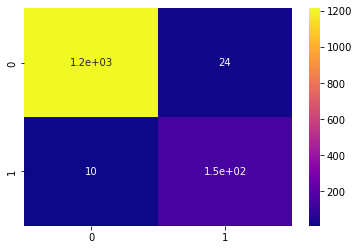

In [26]:
%%time
from sklearn.metrics import confusion_matrix, classification_report

print("############################## TEST ############################## \n")
y_pred = model.predict(test_datagen)
print(classification_report(test_datagen.labels, y_pred[:,0]>=0.5))
cm = confusion_matrix(test_datagen.labels, y_pred[:,0]>=0.5)
sns.heatmap(cm, cmap='plasma', annot=True);

### w/ Data augmentation

In [30]:
%%time 
from tensorflow.keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=5e-4),
              metrics=['acc', f1])
              
checkpoint_cb = callbacks.ModelCheckpoint("models/cnn_TrLr_w_DA.h5", save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5)

result = model.fit(train_datagen, steps_per_epoch=len(train_datagen),
                   validation_data=valid_datagen, validation_steps=len(valid_datagen),
                   epochs=100, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
98/98 [==============================] - 388s 4s/step - loss: 0.0943 - acc: 0.9676 - f1: 0.8355 - val_loss: 0.1019 - val_acc: 0.9676 - val_f1: 0.8612
Epoch 2/100
98/98 [==============================] - 328s 3s/step - loss: 0.0816 - acc: 0.9723 - f1: 0.8548 - val_loss: 0.1065 - val_acc: 0.9626 - val_f1: 0.8305
Epoch 3/100
98/98 [==============================] - 580s 6s/step - loss: 0.0749 - acc: 0.9733 - f1: 0.8644 - val_loss: 0.1061 - val_acc: 0.9633 - val_f1: 0.8467
Epoch 4/100
98/98 [==============================] - 656s 7s/step - loss: 0.0677 - acc: 0.9767 - f1: 0.8844 - val_loss: 0.1168 - val_acc: 0.9576 - val_f1: 0.8149
Epoch 5/100
98/98 [==============================] - 626s 6s/step - loss: 0.0578 - acc: 0.9786 - f1: 0.8901 - val_loss: 0.1443 - val_acc: 0.9648 - val_f1: 0.8302
Epoch 6/100
98/98 [==============================] - 626s 6s/step - loss: 0.0622 - acc: 0.9766 - f1: 0.8746 - val_loss: 0.1086 - val_acc: 0.9633 - val_f1: 0.8131
CPU times: user 31min 13s, s

############################## TEST ############################## 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1236
           1       0.93      0.76      0.83       156

    accuracy                           0.97      1392
   macro avg       0.95      0.87      0.91      1392
weighted avg       0.97      0.97      0.96      1392

CPU times: user 25.9 s, sys: 3.34 s, total: 29.3 s
Wall time: 58 s


<AxesSubplot:>

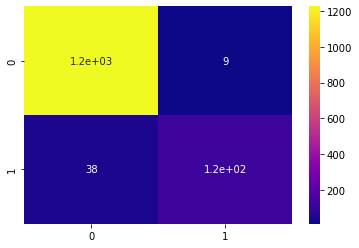

In [31]:
%%time
from sklearn.metrics import confusion_matrix, classification_report

print("############################## TEST ############################## \n")
y_pred = model.predict(test_datagen)
print(classification_report(test_datagen.labels, y_pred[:,0]>=0.5))
cm = confusion_matrix(test_datagen.labels, y_pred[:,0]>=0.5)
sns.heatmap(cm, cmap='plasma', annot=True);